 # Applying deep learning models to Databowl
 Here I use tensorflow to build a feedforward neural net to predict yards
 gained on each rushing play.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_docs as tfdocs

np.set_printoptions(1)


 The feature engineering notebok does a pretty good job of cleaning up the
 data, but leaves behind just a couple NA entries. We drop those rows, mostly
 for convenience.

In [2]:
data = pd.read_csv("data/fe_data.csv", index_col=[0,1])
data.dropna(inplace=True)


 For this iteration, we're using only one line of data for each play--the data
 entry for the rusher. Because `IsRusher` and `IsOffense` are redundant as a
 result, we'll drop those columns from the the dataset. Then we can normalize
 all values so that they are well-interpreted by the model.

In [3]:
plays = data.loc[data.IsRusher]
plays = plays.astype(np.float32)

target = plays.pop("Yards")

plays.drop(["IsRusher","IsOffense"], axis=1, inplace=True)
plays_stats = plays.describe().transpose()

def norm(x):
    return (x - plays_stats['mean']) / plays_stats['std']

norm_data = norm(plays)


In [4]:
x = norm_data.values.astype(np.float32)
y = target.values.astype(np.float32)

dataset = tf.data.Dataset.from_tensor_slices((x, y))


 We can verify that the data arrived in the `tf.data` API all in one piece.

In [5]:
for f,t in dataset.take(5):
    print(f"Features:\n{f}")
    print(f"Target: {t}")
    print()


Features:
[-1.7  1.   1.1 -0.6  0.8 -0.6  0.8  0.3 -1.1  0.5 -1.3  1.5  2.2 -1.7
 -1.1 -1.  -0.9 -1.  -0.6 -0.9 -1.5 -1.1  0.7  1.   0.9  1.  -0.  -0.
 -0.5 -0.1 -0.2  1.5 -0.9 -0.1 -0.5 -0.6 -0.  -0.6 -0.5  1.3]
Target: 8.0

Features:
[-1.7  1.   0.1 -1.1 -0.2 -1.   0.3 -0.8 -1.1  1.1 -1.3  1.4 -0.8  0.4
 -1.1 -1.  -0.9 -1.  -0.6 -0.9 -1.5 -1.1 -0.5  1.   0.9  1.  -0.  -0.
 -0.5 -0.1 -0.2  1.5 -0.9 -0.1 -0.5 -0.6 -0.  -0.3 -0.2  0.9]
Target: 3.0

Features:
[-1.7  1.  -2.2  1.3 -0.2  1.4  1.1  0.7 -1.1  0.5 -1.3  1.2 -0.8  0.4
 -1.1 -1.   0.1 -1.  -0.6 -0.9 -1.5 -1.1 -0.4  1.  -1.1 -1.  -0.  -0.
 -0.5 -0.1 -0.2 -0.7  1.1 -0.1 -0.5  1.6 -0.   0.6  0.7  1.4]
Target: 5.0

Features:
[-1.7e+00  9.9e-01 -4.2e-01  1.2e-01  6.0e-01  1.3e-01  5.4e-01 -2.0e-01
 -1.1e+00 -2.0e+00 -1.3e+00  1.0e+00  7.1e-01 -1.7e+00 -1.1e+00 -1.0e+00
  2.1e+00 -9.9e-01 -7.4e-02 -5.2e-01 -1.5e+00 -1.1e+00  1.5e+00  9.9e-01
 -1.1e+00 -9.7e-01 -5.7e-03 -3.1e-02 -5.0e-01  6.7e+00 -1.8e-01 -6.6e-01
 -8.9e-01 -5.0e-02 -

 Now we can segment this into a training dataset using the API.

In [6]:
train_data = dataset.shuffle(len(norm_data)).batch(100)


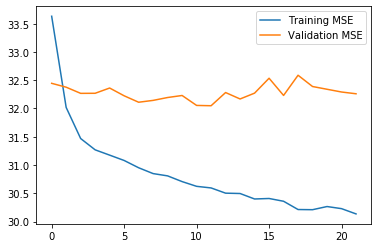

In [7]:
def compile_model():
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(x.shape[1], name='input'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(16, activation='relu', name='hidden'),
        tf.keras.layers.Dense(1, name='output')
    ])

    rms = tf.keras.optimizers.RMSprop(0.001)
    sgd = tf.keras.optimizers.SGD()
    adam = tf.keras.optimizers.Adam()

    model.compile(optimizer=adam, loss='mse', metrics=['mse','mae'])
    return model

EPOCHS = 100
model = compile_model()

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(x,y, 
    validation_split=0.2, 
    epochs=EPOCHS, 
    callbacks=[early_stop],
    verbose=0
)

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
plt.plot(hist.loss, label='Training MSE')
plt.plot(hist.val_loss, label='Validation MSE')
plt.legend()
plt.show()


 It's pretty clear that this model is immediately overfitting. We'll need to
 look into ways to fundamentally improve it or to drastically improve our
 feature engineering.